<a href="https://colab.research.google.com/github/MukulRaj-704/Spam-Detector/blob/main/Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
paths = '/content/drive/My Drive/Colab-files/enron emails.csv'
df=pd.read_csv(paths, encoding='latin1')
df.shape

(33784, 3)

CHECK ALL PPOSSIBLE MISSING VALUES IN OUR DATASET

In [4]:
# Missing_mask = df['Message'].isnull()
# print(Missing_mask)
# Missing_mask.sum()
# print(Missing_mask.sum())


# Alternate to do the same thing above
total_missing = df.isnull().sum()
print(total_missing)

Message           3
Category         83
Unnamed: 2    33781
dtype: int64


HERE WE CAN EASILY SEE THE TOTAL NO OF MISSING VALUES

SO FOR BETTER PREPROCESSING DROP THESE MISSING VALUES ROWS

In [5]:
drop_df = df.dropna(subset=['Message','Category'])
print(drop_df)

                                                 Message Category Unnamed: 2
0               Subject: christmas tree farm pictures\r       ham        NaN
1                Subject: re : rankings\r thank you .\r       ham        NaN
2      Subject: leadership development pilot\r sally ...      ham        NaN
3      Subject: key dates and impact of upcoming sap ...      ham        NaN
4      Subject: key hr issues going forward a ) year ...      ham        NaN
...                                                  ...      ...        ...
33779  Subject: do you wish for a more active sex lif...     spam        NaN
33780  Subject: bloow in 5 - 10 times the time\r lear...     spam        NaN
33781  Subject: why didnt you say hi\r there is this ...     spam        NaN
33782  Subject: dear sir , i am interested in it\r hi...     spam        NaN
33783  Subject: \r html\r body\r b\r pwhy not take a ...     spam        NaN

[33698 rows x 3 columns]


NOW WE CONVERT ALL UPPERCASE INTO LOWERCASE

In [6]:
drop_df['Message'] = drop_df['Message'].str.lower()
drop_df.to_csv("updated_file.csv", index=False)

/tmp/ipython-input-6-12384010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_df['Message'] = drop_df['Message'].str.lower()


EXTRACT METADATA FEATURES FROM EMAIL

In [9]:
import re

URL_PATTERN = re.compile(r'http[s]?://(?:[a-zA-Z0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F]{2}))+')
EMAIL_PATTERN = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
SHORTENED_DOMAINS = ['bit.ly', 'goo.gl', 't.co', 'tinyurl.com', 'ow.ly']


def count_urls(text):
    return len(URL_PATTERN.findall(str(text)))

def extract_urls(text):
    return URL_PATTERN.findall(str(text))

def has_shortened_url(text):
    urls = extract_urls(text)
    return int(any(short in url for short in SHORTENED_DOMAINS for url in urls))

def count_email_addresses(text):
    return len(EMAIL_PATTERN.findall(str(text)))

def count_digits(text):
    return len(re.findall(r'\d', str(text)))

def count_special_chars(text):
    return len(re.findall(r'[^a-zA-Z0-9\s]', str(text)))

def has_money_keywords(text):
    spam_keywords = ['win', 'cash', 'free', 'offer', 'guarantee', 'prize', 'urgent', 'bonus', '₹', '$']
    text_lower = str(text).lower()
    return int(any(word in text_lower for word in spam_keywords))

def message_length(text):
    return len(str(text))

def num_words(text):
    return len(str(text).split())

def num_lines(text):
    return len(str(text).split('\n'))

def is_reply_or_forward(text):
    text = str(text).lower()
    return int(text.startswith("re:") or text.startswith("fw:"))

def extract_metadata_features(drop_df, message_column='Message'):
    df = drop_df.copy()

    df['num_urls'] = df[message_column].apply(count_urls)
    df['short_urls'] = df[message_column].apply(has_shortened_url)
    df['num_emails'] = df[message_column].apply(count_email_addresses)
    df['num_digits'] = df[message_column].apply(count_digits)

    df['num_special_chars'] = df[message_column].apply(count_special_chars)
    df['has_money_keywords'] = df[message_column].apply(has_money_keywords)
    df['message_length'] = df[message_column].apply(message_length)
    df['num_words'] = df[message_column].apply(num_words)

    df['num_lines'] = df[message_column].apply(num_lines)
    df['is_reply_or_forward'] = df[message_column].apply(is_reply_or_forward)

    return df




In [10]:
drop_dff = extract_metadata_features(drop_df, message_column='Message')
display(drop_dff.head())

,Message,Category,Unnamed: 2,num_urls,short_urls,num_emails,num_digits,num_special_chars,has_money_keywords,message_length,num_words,num_lines,is_reply_or_forward
0,subject: christmas tree farm pictures\r,ham,NaN,0,0,0,0,1,0,39,5,1,0
1,subject: re : rankings\r thank you .\r,ham,NaN,0,0,0,0,3,0,37,7,1,0
2,subject: leadership development pilot\r sally ...,ham,NaN,0,0,0,61,199,1,3605,758,1,0
3,subject: key dates and impact of upcoming sap ...,ham,NaN,0,0,0,32,139,0,3726,675,1,0
4,subject: key hr issues going forward a ) year ...,ham,NaN,0,0,0,0,14,0,338,62,1,0


TF-IDF VECTORIZATION OF EMAIL TEXT

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( stop_words='english', ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(drop_dff['Message'])

In [12]:
feature_names = tfidf_vectorizer.get_feature_names_out()

print(" features:")
print(feature_names[19000:20000])

 features:
['13 questions' '13 raised' '13 range' '13 rating' '13 ravi' '13 rc'
 '13 reached' '13 receipt' '13 received' '13 reply' '13 republicans'
 '13 requested' '13 respond' '13 result' '13 retaildesk' '13 reviews'
 '13 richard' '13 rick' '13 rita' '13 rockets' '13 roe' '13 roundtrip'
 '13 said' '13 sale' '13 san' '13 second' '13 semperger' '13 sent'
 '13 sep' '13 september' '13 set' '13 share' '13 sheila' '13 shijie'
 '13 shirley' '13 similarly' '13 sincerely' '13 sj' '13 smtp' '13 sold'
 '13 sotak' '13 southeastern' '13 sp' '13 spam' '13 spreadsheet' '13 st'
 '13 start' '13 state' '13 states' '13 student' '13 style'
 '13 subcommittee' '13 subject' '13 summer' '13 superscript' '13 tammie'
 '13 tcf' '13 temporarily' '13 terrorism' '13 tft' '13 th' '13 thanks'
 '13 think' '13 thirteen' '13 thursday' '13 ticket' '13 tim' '13 time'
 '13 times' '13 timothy' '13 tina' '13 tol' '13 took' '13 topic'
 '13 total' '13 trade' '13 trading' '13 trans' '13 transwestern' '13 type'
 '13 ucd' '13 u

In [14]:
column = [
    'num_urls', 'short_urls', 'num_emails', 'num_digits', 'num_special_chars', 'has_money_keywords',
    'message_length', 'num_words', 'num_lines', 'is_reply_or_forward'
]

X_meta = drop_dff[column].astype(int).values

COMBINING METADATA AND TF-IDF VECTORIZATION

In [15]:
from scipy.sparse import hstack

X_combined = hstack([X_tfidf, X_meta])


In [16]:
X_combined.shape

(33698, 1612740)

TARGET COLUMN

In [17]:
y = drop_dff['Category']

TRAINING NAIVE-BAYES MOEDL FOR THE PREDICTION




In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report")
print(classification_report(y_test, y_pred))
Accuracy_NB = accuracy_score(y_test, y_pred)
print("Accuracy",Accuracy_NB)

Classification Report
              precision    recall  f1-score   support

         ham       0.76      0.77      0.77      3300
        spam       0.78      0.77      0.77      3440

    accuracy                           0.77      6740
   macro avg       0.77      0.77      0.77      6740
weighted avg       0.77      0.77      0.77      6740

Accuracy 0.7704747774480712


C-MAP VISUALIZATION OF PREDICTION

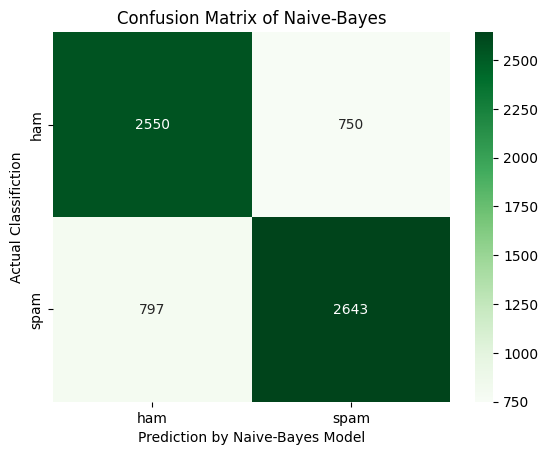

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Prediction by Naive-Bayes Model")
plt.ylabel("Actual Classifiction")
plt.title("Confusion Matrix of Naive-Bayes")
plt.show()

NAIVE-BAYES MODEL ON CUSTOME EMAIL

In [23]:
custom_emails = [
    "Dear Mukul Raj Paawan, We hope you're doing great! Congratulations on your next leap towards a maximized career with Flipkart! You have successfully completed your assessment...",
    "Get FREE access to our exclusive offer — click now and claim your reward!",
    "Hi Mukul, your resume was shortlisted. Please schedule your interview at your convenience.",
    "Warning: Your account will be suspended unless you verify your identity now. Click here to confirm."
]

for i, email in enumerate(custom_emails, 1):

    temp_df = pd.DataFrame({'Message': [email]})

    email_meta = extract_metadata_features(temp_df, message_column='Message')[column].astype(int).values

    email_tfidf = tfidf_vectorizer.transform([email])

    email_combined = hstack([email_tfidf, email_meta])

    prediction = model.predict(email_combined)
    confidence = model.predict_proba(email_combined)

    print(f"\n Email {i}:")
    print(email)
    print("Prediction:", "Spam 🚨" if prediction[0] == 'spam' else "Ham ✅")
    print("Confidence (Ham, Spam):", confidence[0])


 Email 1:
Dear Mukul Raj Paawan, We hope you're doing great! Congratulations on your next leap towards a maximized career with Flipkart! You have successfully completed your assessment...
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.2553306 0.7446694]

 Email 2:
Get FREE access to our exclusive offer — click now and claim your reward!
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.02358601 0.97641399]

 Email 3:
Hi Mukul, your resume was shortlisted. Please schedule your interview at your convenience.
Prediction: Ham ✅
Confidence (Ham, Spam): [0.86552916 0.13447084]

 Email 4:
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.04133066 0.95866934]


TRAINING DECISION TREE MODEL

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(max_depth=20, random_state=42)
dt_model.fit(X_train, y_train)
from sklearn.metrics import classification_report

y_pred = dt_model.predict(X_test)
print("Decision Tree Performance:\n")
print(classification_report(y_test, y_pred))
Accuracy_dt = accuracy_score(y_test, y_pred)
print("Accuracy",Accuracy_dt)

Decision Tree Performance:

              precision    recall  f1-score   support

         ham       0.98      0.90      0.94      3300
        spam       0.91      0.98      0.94      3440

    accuracy                           0.94      6740
   macro avg       0.94      0.94      0.94      6740
weighted avg       0.94      0.94      0.94      6740

Accuracy 0.9409495548961424


C-MAP OF DECISION TREE MODEL

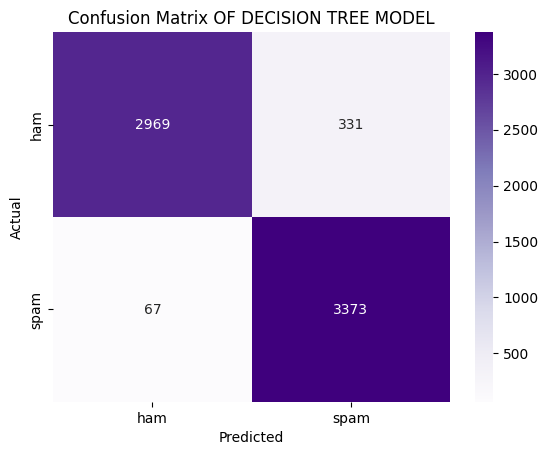

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix OF DECISION TREE MODEL")
plt.show()

DECISION TREE MODEL ON CUSTOM EMAILS

In [28]:
custom_emails = [
    "Dear Mukul Raj Paawan, We hope you're doing great! Congratulations on your next leap towards a maximized career with Flipkart! You have successfully completed your assessment...",
    "Get FREE access to our exclusive offer — click now and claim your reward!",
    "Hi Mukul, your resume was shortlisted. Please schedule your interview at your convenience.",
    "Warning: Your account will be suspended unless you verify your identity now. Click here to confirm."
]

for i, email in enumerate(custom_emails, 1):

    temp_df = pd.DataFrame({'Message': [email]})

    email_meta = extract_metadata_features(temp_df, message_column='Message')[column].astype(int).values

    email_tfidf = tfidf_vectorizer.transform([email])

    email_combined = hstack([email_tfidf, email_meta])

    prediction = dt_model.predict(email_combined)
    confidence = dt_model.predict_proba(email_combined)

    print(f"\n Email {i}:")
    print(email)
    print("Prediction:", "Spam 🚨" if prediction[0] == 'spam' else "Ham ✅")
    print("Confidence (Ham, Spam):", confidence[0])


 Email 1:
Dear Mukul Raj Paawan, We hope you're doing great! Congratulations on your next leap towards a maximized career with Flipkart! You have successfully completed your assessment...
Prediction: Ham ✅
Confidence (Ham, Spam): [1. 0.]

 Email 2:
Get FREE access to our exclusive offer — click now and claim your reward!
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.18030691 0.81969309]

 Email 3:
Hi Mukul, your resume was shortlisted. Please schedule your interview at your convenience.
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.18030691 0.81969309]

 Email 4:
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.18030691 0.81969309]


TRAINING RANDOM FOREST MODEL

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)
from sklearn.metrics import classification_report

y_pred = rf_model.predict(X_test)
print("Random Forest Performance:\n")
print(classification_report(y_test, y_pred))
Accuracy_RF = accuracy_score(y_test, y_pred)
print("Accuracy",Accuracy_RF)

Random Forest Performance:

              precision    recall  f1-score   support

         ham       1.00      0.85      0.92      3300
        spam       0.88      1.00      0.93      3440

    accuracy                           0.93      6740
   macro avg       0.94      0.92      0.93      6740
weighted avg       0.93      0.93      0.93      6740

Accuracy 0.9262611275964392


C-MAP OF RANDOM FOREST

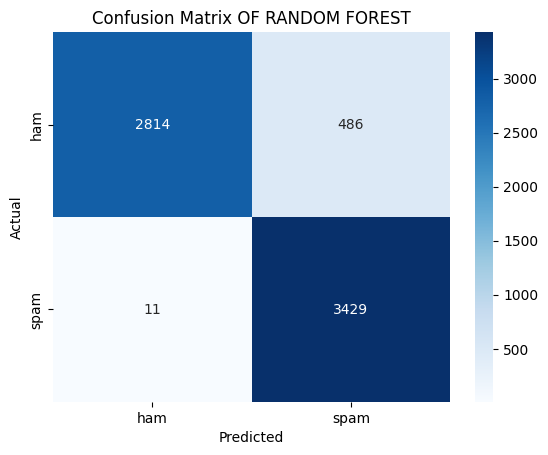

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix OF RANDOM FOREST")
plt.show()

RANDOM FOREST ON CUSTOM EMAILS

In [33]:
custom_emails = [
    "Dear Mukul Raj Paawan, We hope you're doing great! Congratulations on your next leap towards a maximized career with Flipkart! You have successfully completed your assessment...",
    "Get FREE access to our exclusive offer — click now and claim your reward!",
    "Hi Mukul, your resume was shortlisted. Please schedule your interview at your convenience.",
    "Warning: Your account will be suspended unless you verify your identity now. Click here to confirm."
]

for i, email in enumerate(custom_emails, 1):

    temp_df = pd.DataFrame({'Message': [email]})

    email_meta = extract_metadata_features(temp_df, message_column='Message')[column].astype(int).values

    email_tfidf = tfidf_vectorizer.transform([email])

    email_combined = hstack([email_tfidf, email_meta])

    prediction = rf_model.predict(email_combined)
    confidence = rf_model.predict_proba(email_combined)

    print(f"\n Email {i}:")
    print(email)
    print("Prediction:", "Spam 🚨" if prediction[0] == 'spam' else "Ham ✅")
    print("Confidence (Ham, Spam):", confidence[0])


 Email 1:
Dear Mukul Raj Paawan, We hope you're doing great! Congratulations on your next leap towards a maximized career with Flipkart! You have successfully completed your assessment...
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.47392325 0.52607675]

 Email 2:
Get FREE access to our exclusive offer — click now and claim your reward!
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.43649157 0.56350843]

 Email 3:
Hi Mukul, your resume was shortlisted. Please schedule your interview at your convenience.
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.46856713 0.53143287]

 Email 4:
Prediction: Spam 🚨
Confidence (Ham, Spam): [0.44202881 0.55797119]
